In [1]:
import re
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import pearsonr
plt.style.use("seaborn")
%matplotlib inline

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/P3/df_tmp.csv")
print(f"Nombre d'observations: {data.shape[0]}")
print(f"Nombre de variables: {data.shape[1]}")
print("5 premières observations")
display(data.head())

<ipython-input-1-2e1dc8efba3d>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Nombre d'observations: 36513
Nombre de variables: 14
5 premières observations


,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,sodium_100g,sugars_100g,proteins_100g,salt_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,energy_100g
0,40608754.0,"pepsi, nouveau goût !",pepsi,e,beverages,sweetened beverages,0.010000,10.4,0.0,0.0254,0.0,10.4,0.0,177.0
1,87177756.0,7up,"7up,pepsico",e,beverages,sweetened beverages,0.039370,10.4,0.0,0.1000,0.0,10.4,0.0,177.0
2,10.0,madeleines nature,bijou,d,sugary snacks,biscuits and cakes,0.259843,26.0,6.0,0.6600,2.5,55.0,23.0,1900.0
3,30.0,cakes raisins,bijou,d,sugary snacks,biscuits and cakes,0.255906,28.0,5.8,0.6500,2.5,56.0,19.0,1768.0
4,31.0,cakes aux fruits,bijou,d,sugary snacks,biscuits and cakes,0.236220,34.0,4.9,0.6000,2.0,60.0,15.0,1670.0


In [2]:
data.describe(include= 'all')

,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,sodium_100g,sugars_100g,proteins_100g,salt_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,energy_100g
count,3.651300e+04,36513,36513,36513,36513,36513,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000,36513.000000
unique,NaN,29549,6515,5,9,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,lait demi-écrémé,carrefour,d,sugary snacks,one dish meals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,40,1524,9959,7272,3843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.739366e+12,NaN,NaN,NaN,NaN,NaN,0.342345,12.953277,7.777660,0.869553,5.000711,27.910357,12.175483,1062.517552
std,4.923896e+12,NaN,NaN,NaN,NaN,NaN,0.564599,18.389709,7.276466,1.433972,7.132954,26.438572,13.573772,722.979608
min,1.000000e+01,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.229821e+12,NaN,NaN,NaN,NaN,NaN,0.031496,1.100000,2.000000,0.080000,0.300000,4.800000,1.500000,407.000000
50%,3.274937e+12,NaN,NaN,NaN,NaN,NaN,0.230000,4.100000,6.100000,0.584200,1.800000,17.000000,7.700000,1001.000000
75%,3.596710e+12,NaN,NaN,NaN,NaN,NaN,0.472441,16.000000,11.000000,1.200000,7.000000,52.000000,19.400000,1616.000000


# 1.DISTRIBUTION DES VARIABLES

# VARIABLE 'energy_100g':

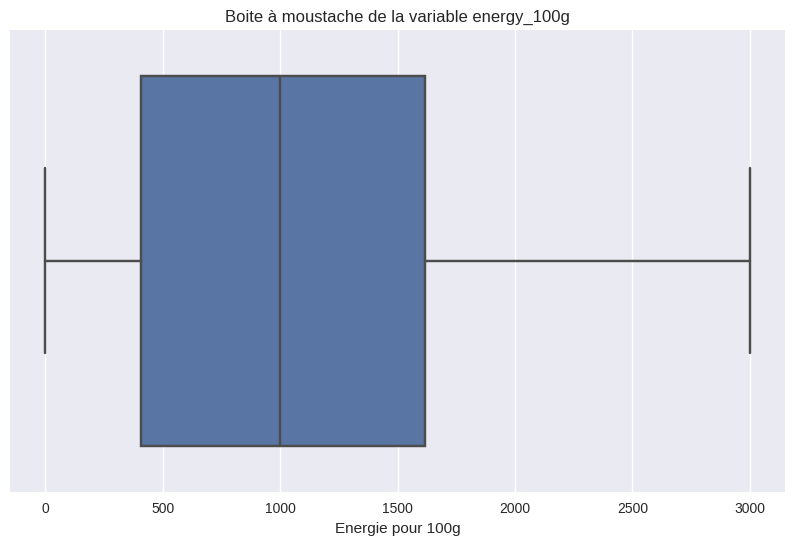

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution


count    36513.000000
mean      1062.517552
std        722.979608
min          0.000000
25%        407.000000
50%       1001.000000
75%       1616.000000
max       3000.000000
Name: energy_100g, dtype: float64

In [3]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=data, x='energy_100g')
ax.set_title("Boite à moustache de la variable energy_100g")
ax.set_xlabel("Energie pour 100g")

plt.show()
print('-' * 223)
print("Indicateurs de distribution")
data["energy_100g"].describe()

Les valeurs sont concentrées dans l'interval inter-quartile entre 420 et 1624. La boîte à moustache montre de nombreuses observations qui ont des valeurs atypiques située au delà de la borne supérieur de 1,5 interquartile. Viusalisons ces données.

In [4]:
def check_outliers(df, col):
    """
    Retrive all outliers which are out or a 3 IQR range for a single series.

    Args:
        df(Dataframe): A pandas dataframe
        col(Dataframe series): A pandas Series to check outliers

    Returns
        q1(float): value of the first quartile
        q3(float): value of the third quartile
        iqr(float): inter quartile range
        outliers(dataframe): Filtered datarame with ouliers values
    """

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers = df[(df[col] < fence_low) | (df[col] > fence_high)]

    print(f"Premier quartile: {q1}")
    print(f"Troisième quartile: {q3}")
    print(f"Intervale inter-quartiles: {iqr}")
    print(f"Nombre d'observations en dehors de l'interval de 3 inter-quartiles dites atypiques: {outliers.shape[0]} ")
    print(f"Proportions des valeurs atypiques {outliers.shape[0]/data.shape[0]*100:.2f}%")

    return q1, q3, iqr, outliers

_, _, _, energy_100g_outliers = check_outliers(data, "energy_100g")
print("20 plus hautes valeurs atypiques")
display(energy_100g_outliers.sort_values("energy_100g").head(20))

energy_100g_by_pnns = energy_100g_outliers.sort_values("energy_100g").loc[:,["product_name",
                                                             "pnns_groups_1",
                                                             "pnns_groups_2"]].groupby(["pnns_groups_1",
                                                                                        "pnns_groups_2"]).agg("count").sort_values(["product_name"], ascending=False)

energy_100g_by_pnns.reset_index(inplace=True)
energy_100g_by_pnns.rename(mapper={"product_name":"nombre_observations"}, axis=1, inplace=True)

print("Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 ")
display(energy_100g_by_pnns)

Premier quartile: 407.0
Troisième quartile: 1616.0
Intervale inter-quartiles: 1209.0
Nombre d'observations en dehors de l'interval de 3 inter-quartiles dites atypiques: 0 
Proportions des valeurs atypiques 0.00%
20 plus hautes valeurs atypiques


,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,sodium_100g,sugars_100g,proteins_100g,salt_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,energy_100g


Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 


,pnns_groups_1,pnns_groups_2,nombre_observations


On peut voir que qu'il n'y a pas de valeurs atypiques sur la variable energy_100g.



# VARIABLE 'proteins_100g'

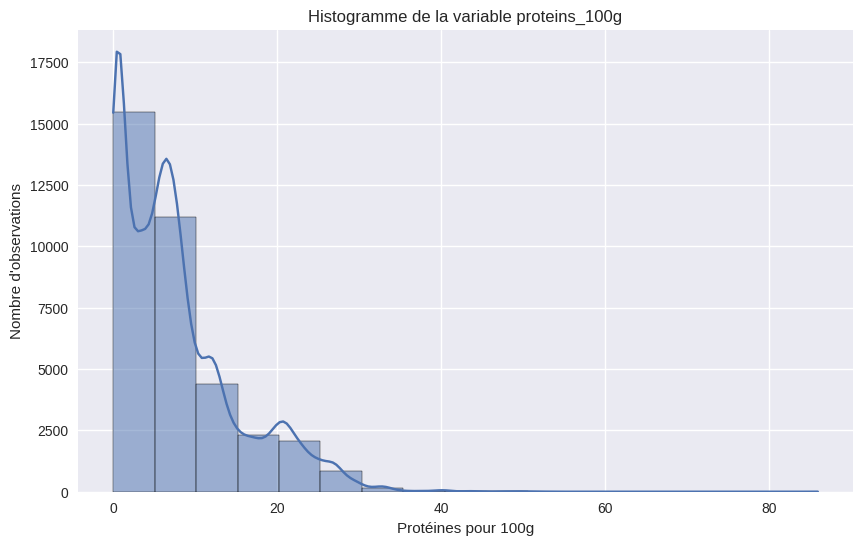

In [5]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x='proteins_100g', bins="sturges", kde=True)
ax.set_xlabel("Protéines pour 100g")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Histogramme de la variable proteins_100g")

plt.show()

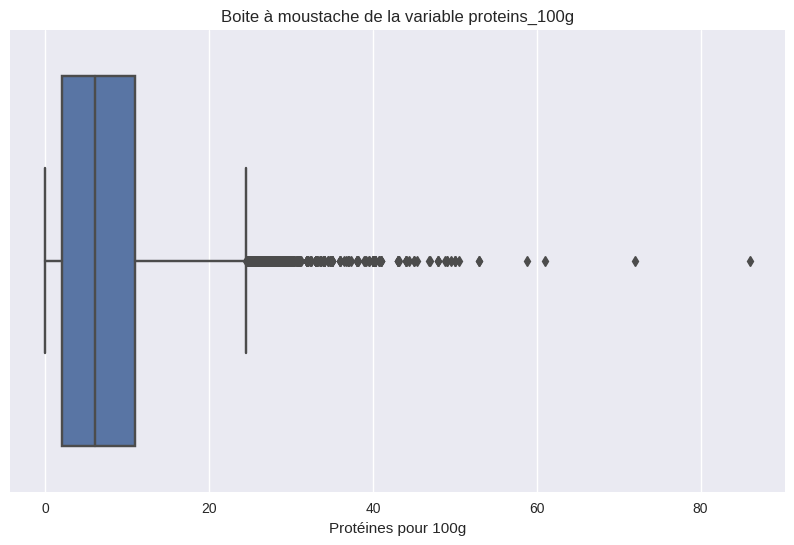

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution


count    36513.000000
mean         7.777660
std          7.276466
min          0.000000
25%          2.000000
50%          6.100000
75%         11.000000
max         86.000000
Name: proteins_100g, dtype: float64

In [6]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=data, x='proteins_100g')
ax.set_title("Boite à moustache de la variable proteins_100g")
ax.set_xlabel("Protéines pour 100g")

plt.show()
print('-' * 223)
print("Indicateurs de distribution")
data["proteins_100g"].describe()

In [7]:
_, _, _, proteins_100g_outliers = check_outliers(data, "proteins_100g")

print("20 plus hautes valeurs atypiques")
display(proteins_100g_outliers.sort_values("energy_100g").head(20))

proteins_100g_by_pnns = proteins_100g_outliers.sort_values("proteins_100g").loc[:,["product_name",
                                                             "pnns_groups_1",
                                                             "pnns_groups_2"]].groupby(["pnns_groups_1",
                                                                                        "pnns_groups_2"]).agg("count").sort_values(["product_name"], ascending=False)

proteins_100g_by_pnns.reset_index(inplace=True)
proteins_100g_by_pnns.rename(mapper={"product_name":"nombre_observations"}, axis=1, inplace=True)

print("Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 ")
display(proteins_100g_by_pnns)

Premier quartile: 2.0
Troisième quartile: 11.0
Intervale inter-quartiles: 9.0
Nombre d'observations en dehors de l'interval de 3 inter-quartiles dites atypiques: 1321 
Proportions des valeurs atypiques 3.62%
20 plus hautes valeurs atypiques


,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,sodium_100g,sugars_100g,proteins_100g,salt_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,energy_100g
17030,3.256224e+12,emmental français râpé (28 % mg),u,c,milk and dairy products,cheese,0.350394,0.0,27.0,0.89000,21.00,0.000000,29.000000,1.0
27147,3.092719e+12,sirop fraise,teisseire,e,beverages,non sugared beverages,0.000000,10.6,86.0,0.00000,0.00,10.600000,0.000000,180.0
22146,3.043933e+12,bte 300g lait en poudre ecreme vitalite regilait,regilait,d,milk and dairy products,milk and yogurt,0.433071,51.0,35.0,1.10000,0.50,51.000000,0.800000,368.0
34707,8.420403e+12,lupins,aceitunas-sarasa,c,cereals and potatoes,legumes,1.377953,0.0,39.0,3.50000,0.00,10.500000,2.000000,412.0
36228,8.934874e+12,nước mắm,hưng thành,d,fat and sauces,dressings and sauces,9.490000,0.0,26.0,24.10460,0.00,0.000000,0.000000,418.0
11978,3.222473e+12,haddock fumé au bois de hêtre,casino,d,fish meat eggs,fish and seafood,1.311024,0.0,25.2,3.33000,0.11,0.000000,0.480000,435.0
8993,3.263851e+12,morceaux de thon au naturel,leader price,b,fish meat eggs,fish and seafood,0.393701,0.0,25.0,1.00000,0.20,0.000000,0.500000,439.0
9002,3.596710e+12,morceaux de thon au naturel,"pouce,auchan",b,fish meat eggs,fish and seafood,0.433071,0.1,25.0,1.10000,0.20,27.910357,12.175483,439.0
8380,3.564700e+12,"thon entier albacore, au naturel","pêche océan,marque repère",b,fish meat eggs,fish and seafood,0.420000,0.0,25.0,1.06680,0.00,0.000000,0.500000,440.0
8407,5.410363e+12,thon au naturel,imperial,b,fish meat eggs,fish and seafood,0.397638,0.0,25.0,1.01000,0.20,0.000000,0.500000,444.0


Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 


,pnns_groups_1,pnns_groups_2,nombre_observations
0,milk and dairy products,cheese,464
1,fish meat eggs,processed meat,396
2,fish meat eggs,fish and seafood,133
3,salty snacks,nuts,98
4,cereals and potatoes,legumes,69
5,fish meat eggs,meat,59
6,fruits and vegetables,vegetables,21
7,composite foods,one dish meals,18
8,sugary snacks,sweets,16
9,cereals and potatoes,cereals,15


Mesure d'asymétrie empirique de la variable proteins_100g: 1.3431384614490127
Messure d'aplatissement empirique de la variable proteins_100g: 2.1793501416386056
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:282: RuntimeWarning: invalid value encountered in divide
  return (self.sorted_data - self.loc) / self.scale


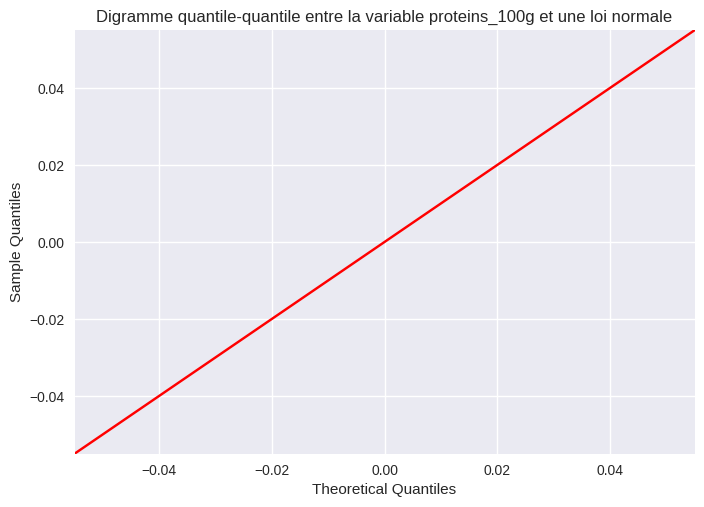

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=1.0, pvalue=1.0)

In [8]:
#Terminons l'analyse de la variable en observant ses indicateurs de forme et en testant sa normalité.
from scipy.stats import shapiro
print(f"Mesure d'asymétrie empirique de la variable proteins_100g: {data['proteins_100g'].skew(axis=0)}")
print(f"Messure d'aplatissement empirique de la variable proteins_100g: {data['proteins_100g'].kurtosis(axis=0)}")
print("-"*50)
sm.qqplot(data["proteins_100g"].notna(), fit=True, line="45")
plt.title("Digramme quantile-quantile entre la variable proteins_100g et une loi normale")
plt.show()

shapiro(data["proteins_100g"].notna())

L'hypothèse H0 de normalité peut être rejetée avec un risque de 7%

# VARIABLE sugars_100g

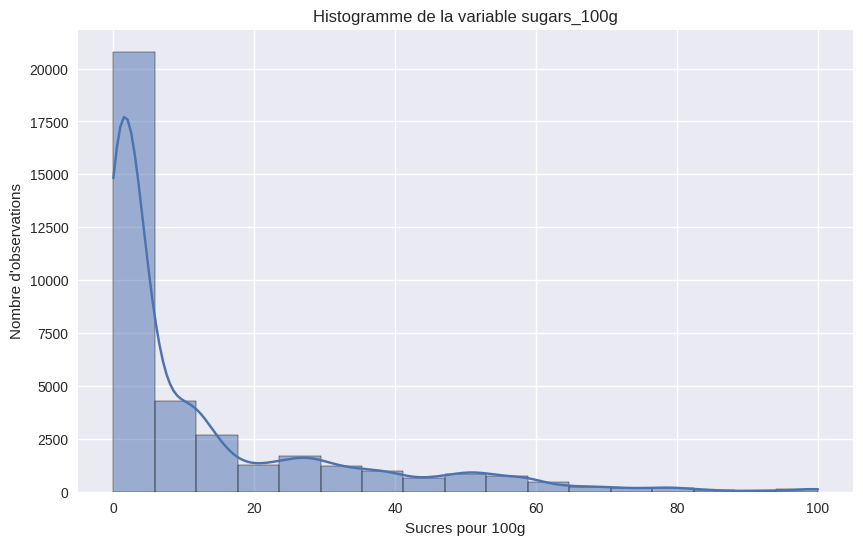

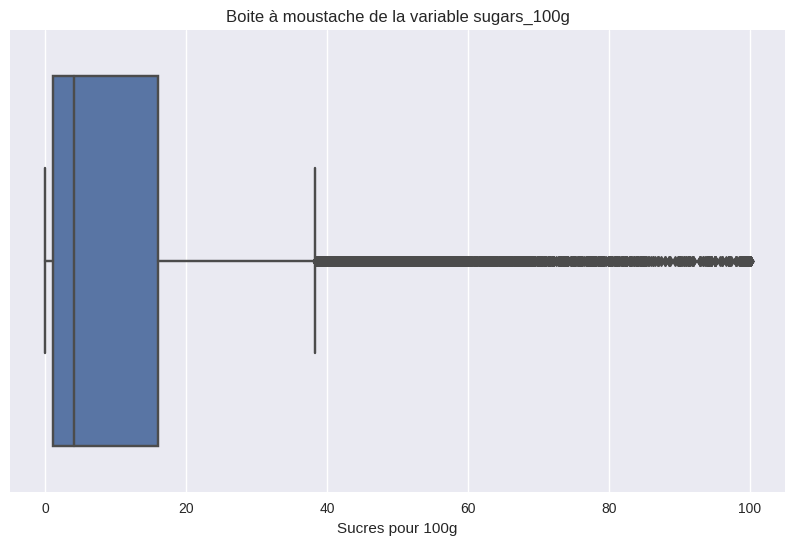

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution


count    36513.000000
mean        12.953277
std         18.389709
min          0.000000
25%          1.100000
50%          4.100000
75%         16.000000
max        100.000000
Name: sugars_100g, dtype: float64

In [9]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x='sugars_100g', bins="sturges", kde=True)
ax.set_xlabel("Sucres pour 100g")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Histogramme de la variable sugars_100g")

plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=data, x='sugars_100g')
ax.set_title("Boite à moustache de la variable sugars_100g")
ax.set_xlabel("Sucres pour 100g")

plt.show()
print('-' * 223)
print("Indicateurs de distribution")
data["sugars_100g"].describe()

De manière plus précise la distributions des variables est concentrée entre 1 et 17.

Etudions les valeurs atypiques

In [10]:
_, _, _, sugars_100g_outliers = check_outliers(data, "sugars_100g")

print("20 plus hautes valeurs atypiques")
display(sugars_100g_outliers.sort_values("sugars_100g").head(20))

sugars_100g_by_pnns = sugars_100g_outliers.sort_values("sugars_100g").loc[:,["product_name",
                                                             "pnns_groups_1",
                                                             "pnns_groups_2"]].groupby(["pnns_groups_1",
                                                                                        "pnns_groups_2"]).agg("count").sort_values(["product_name"], ascending=False)

proteins_100g_by_pnns.reset_index(inplace=True)
proteins_100g_by_pnns.rename(mapper={"product_name":"nombre_observations"}, axis=1, inplace=True)

print("Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 ")
display(sugars_100g_by_pnns)

Premier quartile: 1.1
Troisième quartile: 16.0
Intervale inter-quartiles: 14.9
Nombre d'observations en dehors de l'interval de 3 inter-quartiles dites atypiques: 4047 
Proportions des valeurs atypiques 11.08%
20 plus hautes valeurs atypiques


,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,sodium_100g,sugars_100g,proteins_100g,salt_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,energy_100g
29269,3.263853e+12,financiers aux amandes,marché franprix,e,sugary snacks,biscuits and cakes,0.161000,38.40,9.00,0.408940,13.3,46.9,25.9,1928.0
25225,5.425008e+12,pâte à tartiner au chocolat noir newtree,newtree,d,sugary snacks,sweets,0.041000,38.40,3.10,0.104140,5.7,48.9,8.8,1272.0
29656,3.178530e+12,bonne maman financiers amandes,bonne maman,e,sugary snacks,biscuits and cakes,0.230000,38.40,8.50,0.584200,10.9,50.6,23.8,1900.0
23650,3.418011e+12,chocorêve,comptoir des flandres,d,sugary snacks,sweets,0.070900,38.40,6.10,0.180086,10.6,54.8,15.7,1665.0
34659,8.410100e+12,grand chocolat pâte d'amande noir,"nestlé,nestlé grand chocolat",e,sugary snacks,chocolate products,0.000000,38.40,6.90,0.000000,14.1,48.6,31.1,2139.0
14050,5.030765e+12,délices au caramel au sel de guérande - lightb...,lightbody,e,sugary snacks,biscuits and cakes,0.232283,38.40,5.20,0.590000,15.5,55.8,26.6,2041.0
32541,3.477690e+12,cake fruits quatre tranches,antoinette patisserie,e,sugary snacks,biscuits and cakes,0.045276,38.40,4.70,0.115000,8.3,60.6,14.1,1622.0
32631,3.256223e+12,noir & blanc au cacao saveur vanille,u,e,sugary snacks,biscuits and cakes,0.331000,38.40,6.36,0.841000,10.9,68.0,19.1,2000.0
18095,3.250391e+12,melange gourmand,paquito,c,salty snacks,appetizers,0.002000,38.40,10.80,0.005080,2.3,39.6,27.7,1952.0
34175,8.000500e+12,kinder cards céréales,"kinder,ferrero,cards",e,sugary snacks,biscuits and cakes,0.188189,38.40,11.60,0.478000,12.4,54.0,28.4,2180.0


Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 


product_name
pnns_groups_1           pnns_groups_2                                 
sugary snacks           sweets                                    1691
                        chocolate products                        1172
                        biscuits and cakes                         594
beverages               sweetened beverages                        222
fruits and vegetables   dried fruits                               146
beverages               non sugared beverages                       67
fruits and vegetables   fruits                                      62
fat and sauces          dressings and sauces                        28
cereals and potatoes    cereals                                     14
                        breakfast cereals                           14
salty snacks            appetizers                                  10
beverages               artificially sweetened beverages             8
milk and dairy products dairy desserts                               4
salty snacks            nuts                                         4
milk and dairy products milk and yogurt                              3
sugary snacks           pastries                                     3
fat and sauces          fats                                         2
cereals and potatoes    bread                                        2
milk and dairy products ice cream                                    1

Les modalités de pnns_groups_2 qui regroupent le plus de valeurs atypiques sur la variable sont Sweets (sucreries), Chocolats products (chocolats) et Biscuits and cakes (biscuits et gâteaux)

Mesure d'asymétrie empirique de la variable sugars_100g: 1.964835982466232
Messure d'aplatissement empirique de la variable sugars_100g: 3.6616122710584755
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:282: RuntimeWarning: invalid value encountered in divide
  return (self.sorted_data - self.loc) / self.scale


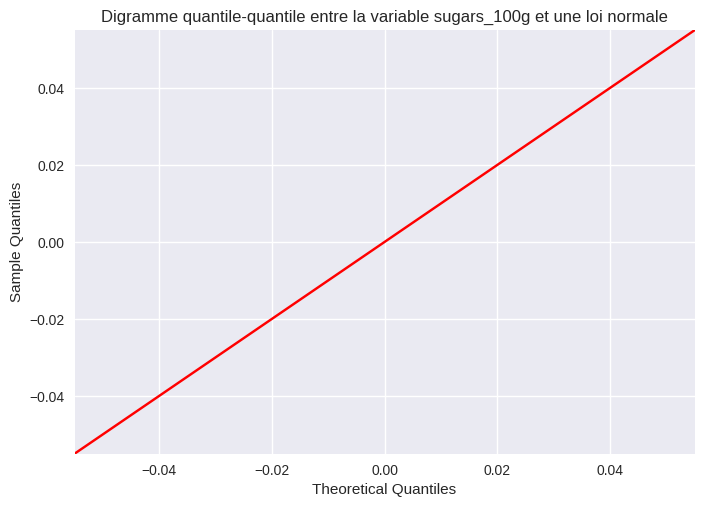

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=1.0, pvalue=1.0)

In [11]:
print(f"Mesure d'asymétrie empirique de la variable sugars_100g: {data['sugars_100g'].skew(axis=0)}")
print(f"Messure d'aplatissement empirique de la variable sugars_100g: {data['sugars_100g'].kurtosis(axis=0)}")
print("-"*50)
sm.qqplot(data["sugars_100g"].notna(), fit=True, line="45")
plt.title("Digramme quantile-quantile entre la variable sugars_100g et une loi normale")
plt.show()

shapiro(data["sugars_100g"].notna())

L'hypothèse H0 de normalité peut être rejetée avec un risque de 5%
Comme les autres variables quantitatives continues la distribution est alongée à droite et plus concentrée qu'une distribution normale. La distribution ne suit pas non plus une loi normale.

# VARIABLE fat_100g

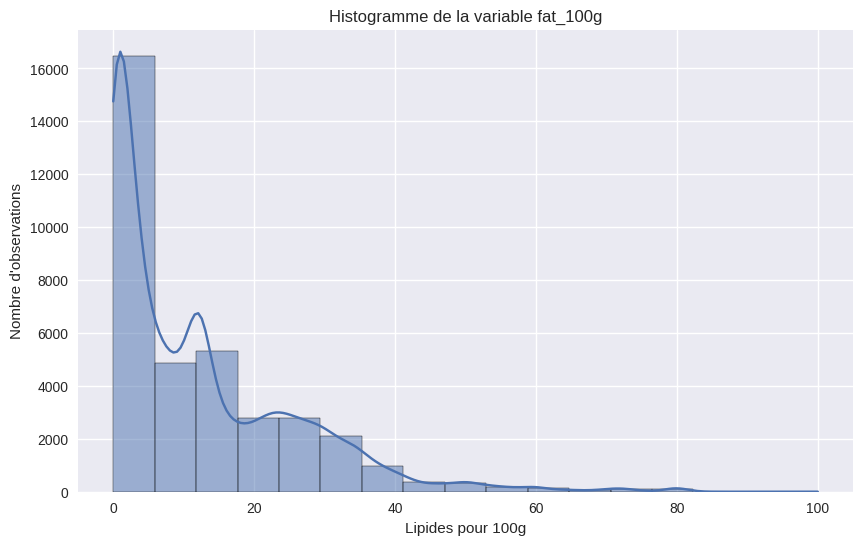

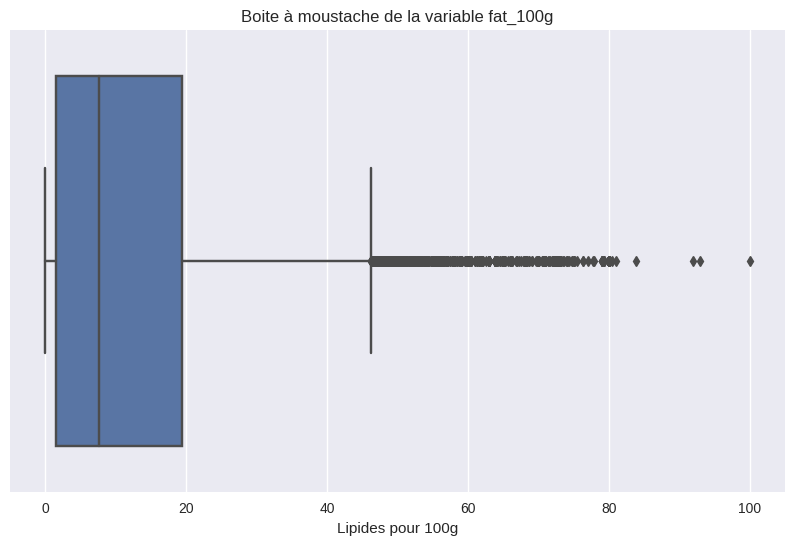

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution


count    36513.000000
mean        12.175483
std         13.573772
min          0.000000
25%          1.500000
50%          7.700000
75%         19.400000
max        100.000000
Name: fat_100g, dtype: float64

In [12]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x='fat_100g', bins="sturges", kde=True)
ax.set_xlabel("Lipides pour 100g")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Histogramme de la variable fat_100g")

plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=data, x='fat_100g')
ax.set_title("Boite à moustache de la variable fat_100g")
ax.set_xlabel("Lipides pour 100g")

plt.show()
print('-' * 223)
print("Indicateurs de distribution")
data["fat_100g"].describe()

La distributoin est concentrée autour de zéro. La majorité des observations ont des valeurs comprises entre de premier quartile (1,3) et le troisième quartile (20.7). Observons les valeurs atypiques.

In [13]:
_, _, _, fat_100g_outliers = check_outliers(data, "fat_100g")

print("20 plus hautes valeurs atypiques")
display(fat_100g_outliers.sort_values("fat_100g").head(20))

fat_100g_by_pnns = fat_100g_outliers.sort_values("fat_100g").loc[:,["product_name",
                                                             "pnns_groups_1",
                                                             "pnns_groups_2"]].groupby(["pnns_groups_1",
                                                                                        "pnns_groups_2"]).agg("count").sort_values(["product_name"], ascending=False)

fat_100g_by_pnns.reset_index(inplace=True)
fat_100g_by_pnns.rename(mapper={"product_name":"nombre_observations"}, axis=1, inplace=True)

print("Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 ")
display(fat_100g_by_pnns)

Premier quartile: 1.5
Troisième quartile: 19.4
Intervale inter-quartiles: 17.9
Nombre d'observations en dehors de l'interval de 3 inter-quartiles dites atypiques: 938 
Proportions des valeurs atypiques 2.57%
20 plus hautes valeurs atypiques


,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,sodium_100g,sugars_100g,proteins_100g,salt_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,energy_100g
12304,3.760074e+12,noix de cajou,pronatura,d,salty snacks,nuts,0.039370,5.00,15.3,0.10000,9.20,32.700000,46.3,2555.0
9281,5.055959e+12,punchy protein nuts,graze,b,fruits and vegetables,dried fruits,0.355000,4.88,22.0,0.90200,6.83,22.200000,46.3,2500.0
29998,3.413880e+12,douceur au chocolat noix d'amazonie,artisans du monde,e,sugary snacks,sweets,0.031496,29.10,9.7,0.08000,13.70,29.600000,46.3,2415.0
20655,3.257984e+12,sauce tartare,cora,d,fat and sauces,dressings and sauces,0.826772,3.40,1.0,2.10000,4.00,6.100000,46.3,1836.0
28170,3.068235e+12,sun croquandises,sun,e,salty snacks,appetizers,0.472441,5.00,15.3,1.20000,9.10,32.700000,46.3,2402.0
24523,3.270721e+12,pistaches grillées salées,daco bello,d,salty snacks,nuts,0.590551,5.40,29.4,1.50000,5.60,12.000000,46.4,2505.0
12430,3.258590e+12,chocolat noir 70% cacao,dardenne,d,sugary snacks,chocolate products,0.000000,25.40,7.7,0.00000,27.40,27.910357,46.4,2496.0
24885,3.347430e+12,chocolat noir bio 74% de cacao,moulin des moines,d,sugary snacks,chocolate products,0.003937,23.10,8.6,0.01000,27.90,30.800000,46.4,2471.0
25329,3.347437e+12,chocolat noir 74% de cacao,moulin des moines,d,sugary snacks,chocolate products,0.003937,23.10,8.6,0.01000,27.90,30.800000,46.4,2471.0
19611,3.760021e+12,pesto tomate parmesan,jardin bio,d,fat and sauces,dressings and sauces,0.885827,5.80,5.2,2.25000,6.40,9.700000,46.5,2014.0


Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 


,pnns_groups_1,pnns_groups_2,nombre_observations
0,salty snacks,nuts,227
1,fat and sauces,fats,225
2,fat and sauces,dressings and sauces,215
3,sugary snacks,chocolate products,91
4,fish meat eggs,fish and seafood,32
5,sugary snacks,sweets,27
6,cereals and potatoes,legumes,25
7,fruits and vegetables,dried fruits,21
8,fish meat eggs,processed meat,18
9,salty snacks,appetizers,17


Mesure d'asymétrie empirique de la variable fat_100g: 1.5948537591523748
Messure d'aplatissement empirique de la variable fat_100g: 3.127731409459359
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:282: RuntimeWarning: invalid value encountered in divide
  return (self.sorted_data - self.loc) / self.scale


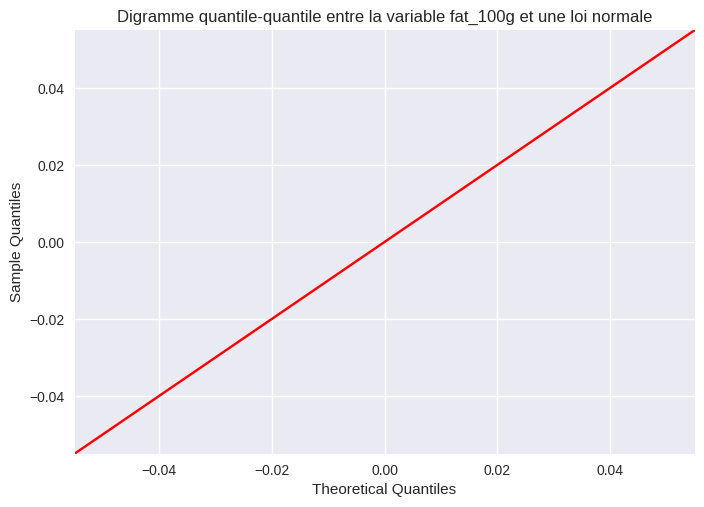

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=1.0, pvalue=1.0)

In [14]:
print(f"Mesure d'asymétrie empirique de la variable fat_100g: {data['fat_100g'].skew(axis=0)}")
print(f"Messure d'aplatissement empirique de la variable fat_100g: {data['fat_100g'].kurtosis(axis=0)}")
print("-"*50)
sm.qqplot(data["fat_100g"].notna(), fit=True, line="45")
plt.title("Digramme quantile-quantile entre la variable fat_100g et une loi normale")
plt.show()

shapiro(data["fat_100g"].notna())

L'hypothèse H0 de normalité peut être rejetée avec un risque de 5%

# VARIABLE saturated-fat_100g

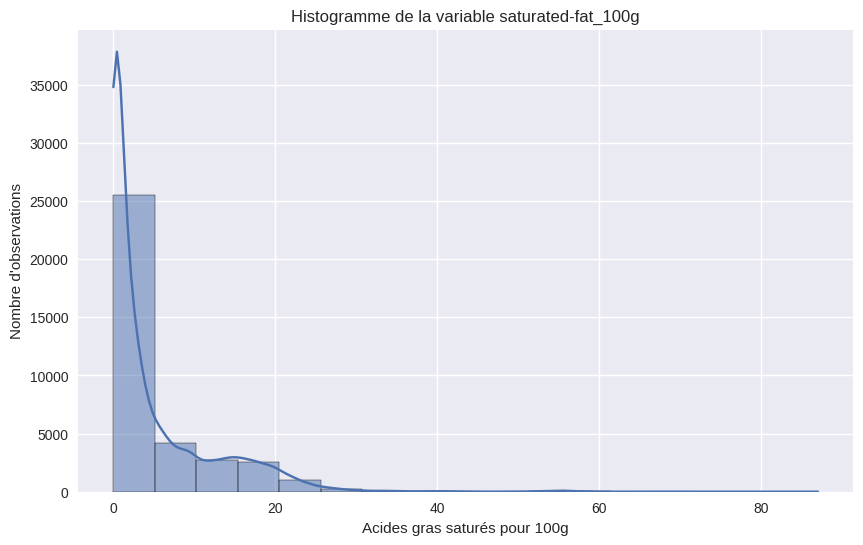

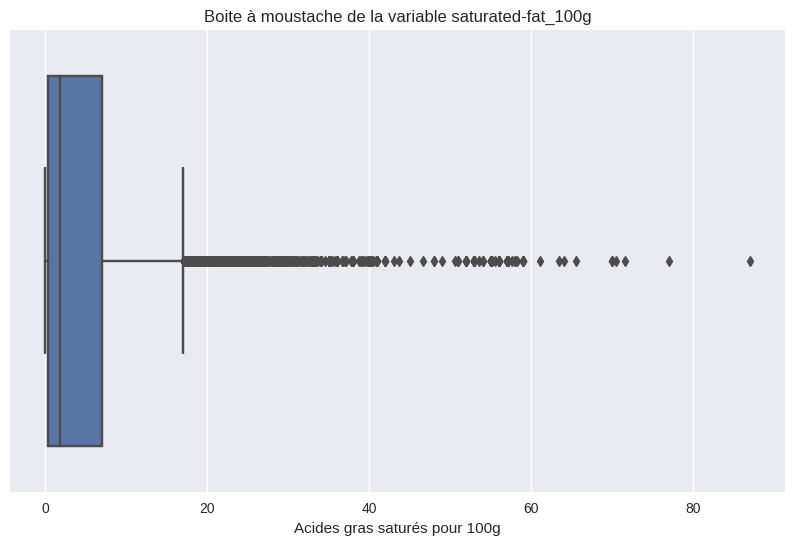

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution


count    36513.000000
mean         5.000711
std          7.132954
min          0.000000
25%          0.300000
50%          1.800000
75%          7.000000
max         87.000000
Name: saturated-fat_100g, dtype: float64

In [15]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x='saturated-fat_100g', bins="sturges", kde=True)
ax.set_xlabel("Acides gras saturés pour 100g")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Histogramme de la variable saturated-fat_100g")

plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=data, x='saturated-fat_100g')
ax.set_title("Boite à moustache de la variable saturated-fat_100g")
ax.set_xlabel("Acides gras saturés pour 100g")

plt.show()
print('-' * 223)
print("Indicateurs de distribution")
data["saturated-fat_100g"].describe()

Les valeurs sont en grande partie regroupées entre le premier quartile (0.3) et le troisième quartile (7). Un certain nombre de valeurs au delà de écart inter-cartiles sont concidérées comme atypiques. Observons les valeurs atypiques

In [16]:
_, _, _, saturated_fat_100g_outliers = check_outliers(data, "saturated-fat_100g")

print("20 plus hautes valeurs atypiques")
display(saturated_fat_100g_outliers.sort_values("saturated-fat_100g").head(20))

saturated_fat_100g_by_pnns = fat_100g_outliers.sort_values("saturated-fat_100g").loc[:,["product_name",
                                                             "pnns_groups_1",
                                                             "pnns_groups_2"]].groupby(["pnns_groups_1",
                                                                                        "pnns_groups_2"]).agg("count").sort_values(["product_name"], ascending=False)

saturated_fat_100g_by_pnns.reset_index(inplace=True)
saturated_fat_100g_by_pnns.rename(mapper={"product_name":"nombre_observations"}, axis=1, inplace=True)

print("Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 ")
display(saturated_fat_100g_by_pnns)

Premier quartile: 0.3
Troisième quartile: 7.0
Intervale inter-quartiles: 6.7
Nombre d'observations en dehors de l'interval de 3 inter-quartiles dites atypiques: 2959 
Proportions des valeurs atypiques 8.10%
20 plus hautes valeurs atypiques


,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,sodium_100g,sugars_100g,proteins_100g,salt_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,energy_100g
36200,8.858135e+12,lait de coco,real thai,d,beverages,non sugared beverages,0.019685,2.0,1.60,0.0500,17.1,2.0,18.5,746.0
26064,3.250392e+12,edam holland les tranchettes,paturages,d,milk and dairy products,cheese,0.799213,0.5,24.50,2.0300,17.1,0.5,24.0,1305.0
20032,3.560071e+12,galettes de riz nappés chocolat noir noix de c...,carrefour bio,d,cereals and potatoes,cereals,0.020000,21.6,6.30,0.0508,17.1,56.5,25.8,2076.0
32966,7.613033e+12,kit kat mini,"nestlé,kit kat",e,sugary snacks,biscuits and cakes,0.050000,50.1,5.40,0.1270,17.1,61.4,29.1,2221.0
32069,3.250391e+12,noir praliné,"ivoria,intermarché",e,sugary snacks,chocolate products,0.015748,46.7,6.70,0.0400,17.1,52.6,32.3,2254.0
14121,5.010775e+12,forme sabre laser rempli de chocolats,kinnerton,e,sugary snacks,chocolate products,0.110236,59.7,5.40,0.2800,17.1,60.6,28.6,2195.0
32573,3.250392e+12,palmiers chocolat au lait,chabrior,e,sugary snacks,biscuits and cakes,0.500000,29.9,6.30,1.2700,17.1,58.8,30.0,2276.0
28983,3.256225e+12,chorizo fort pur porc au piment d'espagne,u,e,fish meat eggs,processed meat,1.800000,1.0,20.10,4.5720,17.1,3.7,50.2,2262.0
30473,3.182650e+12,gâteau breton aux oeufs frais,le glazik,e,sugary snacks,biscuits and cakes,0.437008,24.9,5.90,1.1100,17.1,55.8,27.4,2069.0
32455,3.596710e+12,palmiers nappés au chocolat au lait,auchan,e,sugary snacks,biscuits and cakes,0.452756,29.9,6.30,1.1500,17.1,58.8,30.0,2235.0


Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 


,pnns_groups_1,pnns_groups_2,nombre_observations
0,salty snacks,nuts,227
1,fat and sauces,fats,225
2,fat and sauces,dressings and sauces,215
3,sugary snacks,chocolate products,91
4,fish meat eggs,fish and seafood,32
5,sugary snacks,sweets,27
6,cereals and potatoes,legumes,25
7,fruits and vegetables,dried fruits,21
8,fish meat eggs,processed meat,18
9,salty snacks,appetizers,17


Mesure d'asymétrie empirique de la variable saturated-fat_100g: 2.336956154598078
Messure d'aplatissement empirique de la variable saturated-fat_100g: 8.768943383757737
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:282: RuntimeWarning: invalid value encountered in divide
  return (self.sorted_data - self.loc) / self.scale


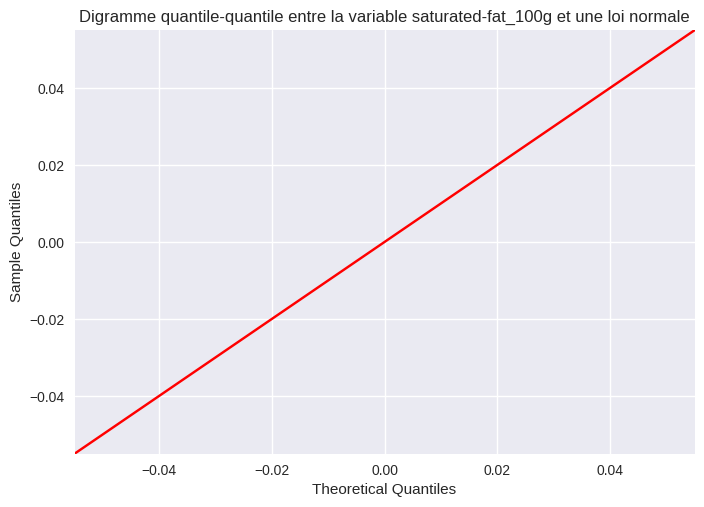

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=1.0, pvalue=1.0)

In [17]:
print(f"Mesure d'asymétrie empirique de la variable saturated-fat_100g: {data['saturated-fat_100g'].skew(axis=0)}")
print(f"Messure d'aplatissement empirique de la variable saturated-fat_100g: {data['saturated-fat_100g'].kurtosis(axis=0)}")
print("-"*50)
sm.qqplot(data["saturated-fat_100g"].notna(), fit=True, line="45")
plt.title("Digramme quantile-quantile entre la variable saturated-fat_100g et une loi normale")
plt.show()

shapiro(data["saturated-fat_100g"].notna())

L'hypothèse H0 de normalité peut être rejetée avec un risque de 5%

# VARIABLE 'carbohydrates_100g' :

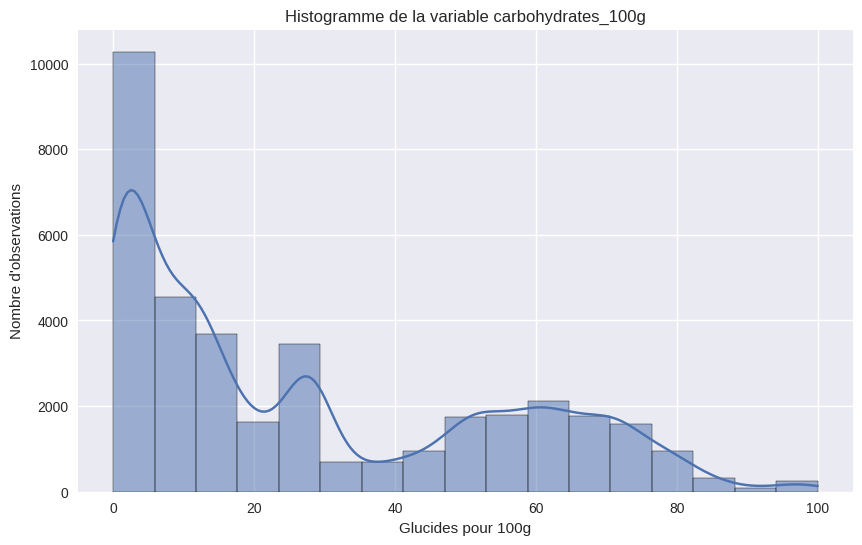

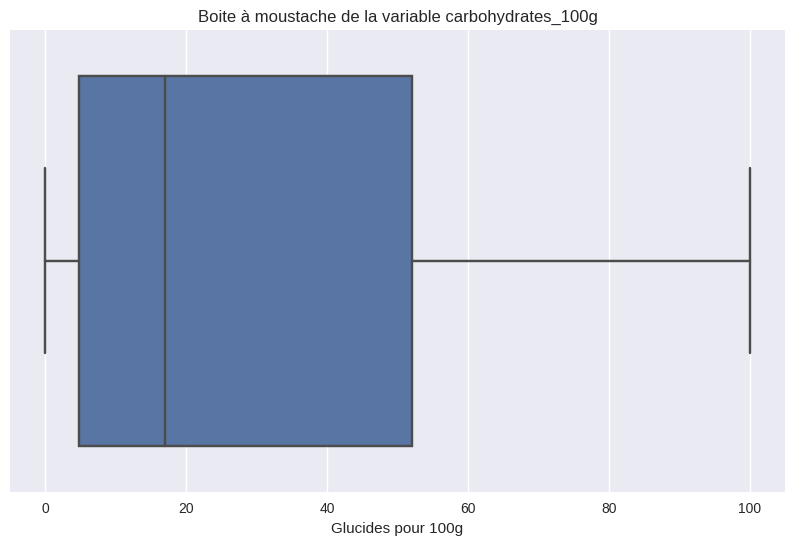

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution


count    36513.000000
mean        27.910357
std         26.438572
min          0.000000
25%          4.800000
50%         17.000000
75%         52.000000
max        100.000000
Name: carbohydrates_100g, dtype: float64

In [18]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x='carbohydrates_100g', bins="sturges", kde=True)
ax.set_xlabel("Glucides pour 100g")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Histogramme de la variable carbohydrates_100g")

plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=data, x='carbohydrates_100g')
ax.set_title("Boite à moustache de la variable carbohydrates_100g")
ax.set_xlabel("Glucides pour 100g")

plt.show()
print('-' * 223)
print("Indicateurs de distribution")
data["carbohydrates_100g"].describe()

D'après la boite à moustaches, il n'y a pas de valeurs atypiques sur la variable carbohydrates_100g

In [19]:
_, _, _, carbohydrates_100g_outliers = check_outliers(data, "carbohydrates_100g")

print("20 plus hautes valeurs atypiques")
display(carbohydrates_100g_outliers.sort_values("carbohydrates_100g").head(20))

carbohydrates_100g_by_pnns = fat_100g_outliers.sort_values("carbohydrates_100g").loc[:,["product_name",
                                                             "pnns_groups_1",
                                                             "pnns_groups_2"]].groupby(["pnns_groups_1",
                                                                                        "pnns_groups_2"]).agg("count").sort_values(["product_name"], ascending=False)

carbohydrates_100g_by_pnns.reset_index(inplace=True)
carbohydrates_100g_by_pnns.rename(mapper={"product_name":"nombre_observations"}, axis=1, inplace=True)

print("Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 ")
display(carbohydrates_100g_by_pnns)

Premier quartile: 4.8
Troisième quartile: 52.0
Intervale inter-quartiles: 47.2
Nombre d'observations en dehors de l'interval de 3 inter-quartiles dites atypiques: 0 
Proportions des valeurs atypiques 0.00%
20 plus hautes valeurs atypiques


,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,sodium_100g,sugars_100g,proteins_100g,salt_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,energy_100g


Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 


,pnns_groups_1,pnns_groups_2,nombre_observations
0,salty snacks,nuts,227
1,fat and sauces,fats,225
2,fat and sauces,dressings and sauces,215
3,sugary snacks,chocolate products,91
4,fish meat eggs,fish and seafood,32
5,sugary snacks,sweets,27
6,cereals and potatoes,legumes,25
7,fruits and vegetables,dried fruits,21
8,fish meat eggs,processed meat,18
9,salty snacks,appetizers,17


Comparons la distribution de la variable avec celle d'une loi normale à l'aide d'un diagramme quantile-quantile et d'un test de Shapiro-Wilk.

Mesure d'asymétrie empirique de la variable carbohydrates_100g: 0.7040817490035391
Messure d'aplatissement empirique de la variable carbohydrates_100g: -0.8543154515299949
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:282: RuntimeWarning: invalid value encountered in divide
  return (self.sorted_data - self.loc) / self.scale


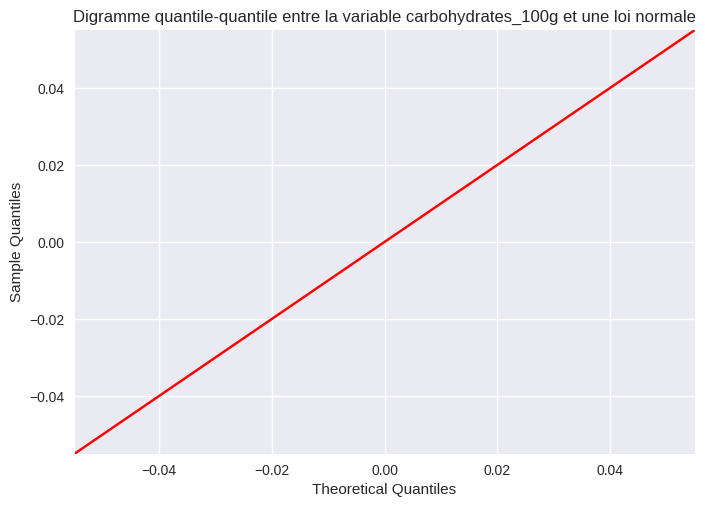

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=1.0, pvalue=1.0)

In [20]:
print(f"Mesure d'asymétrie empirique de la variable carbohydrates_100g: {data['carbohydrates_100g'].skew(axis=0)}")
print(f"Messure d'aplatissement empirique de la variable carbohydrates_100g: {data['carbohydrates_100g'].kurtosis(axis=0)}")
print("-"*50)
sm.qqplot(data["carbohydrates_100g"].notna(), fit=True, line="45")
plt.title("Digramme quantile-quantile entre la variable carbohydrates_100g et une loi normale")
plt.show()

shapiro(data["carbohydrates_100g"].notna())

L'hypothèse H0 de normalité peut être rejetée avec un risque de 5%

# VARIABLE "sodium_100g"

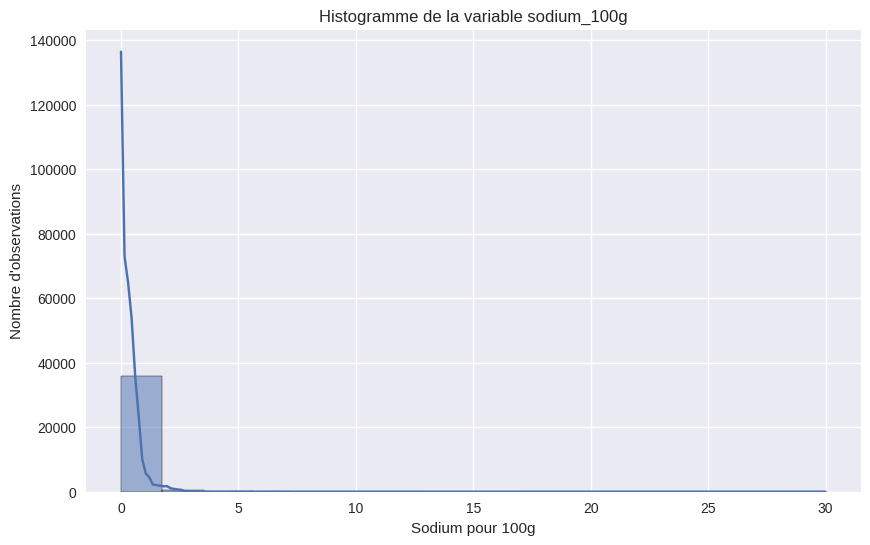

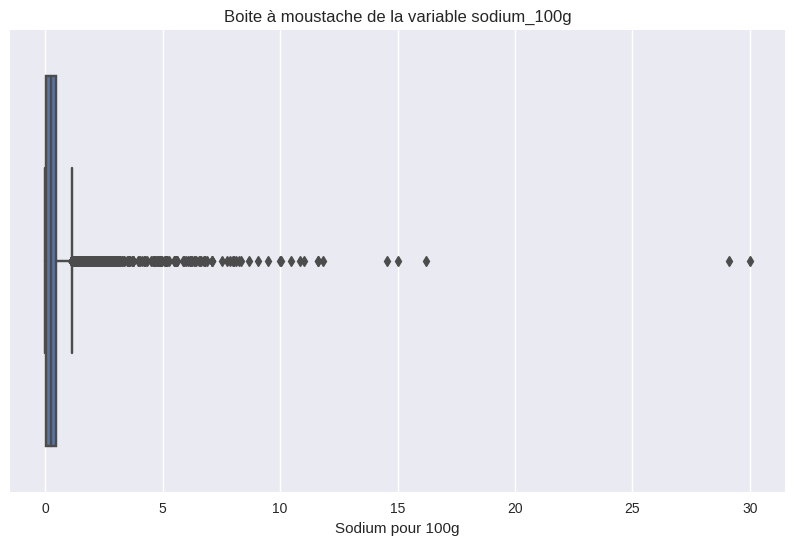

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution


count    36513.000000
mean        27.910357
std         26.438572
min          0.000000
25%          4.800000
50%         17.000000
75%         52.000000
max        100.000000
Name: carbohydrates_100g, dtype: float64

In [21]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x='sodium_100g', bins="sturges", kde=True)
ax.set_xlabel("Sodium pour 100g")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Histogramme de la variable sodium_100g")

plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=data, x='sodium_100g')
ax.set_title("Boite à moustache de la variable sodium_100g")
ax.set_xlabel("Sodium pour 100g")

plt.show()
print('-' * 223)
print("Indicateurs de distribution")
data["carbohydrates_100g"].describe()

Les valeurs sont majoritairement concentrées entre le premier quartile (4,4) et le troisième quartile (53.5). Observons les valeurs situées au delà de 3 intervale inter-quartiles, considérées comme atypiques.

In [22]:
_, _, _, sodium_100g_outliers = check_outliers(data, "sodium_100g")

print("20 plus hautes valeurs atypiques")
display(sodium_100g_outliers.sort_values("sodium_100g").head(20))

sodium_100g_by_pnns = sodium_100g_outliers.sort_values("sodium_100g").loc[:,["product_name",
                                                             "pnns_groups_1",
                                                             "pnns_groups_2"]].groupby(["pnns_groups_1",
                                                                                        "pnns_groups_2"]).agg("count").sort_values(["product_name"], ascending=False)

sodium_100g_by_pnns.reset_index(inplace=True)
sodium_100g_by_pnns.rename(mapper={"product_name":"nombre_observations"}, axis=1, inplace=True)

print("Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 ")
display(sodium_100g_by_pnns)

Premier quartile: 0.031496063
Troisième quartile: 0.472440945
Intervale inter-quartiles: 0.440944882
Nombre d'observations en dehors de l'interval de 3 inter-quartiles dites atypiques: 1630 
Proportions des valeurs atypiques 4.46%
20 plus hautes valeurs atypiques


,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,sodium_100g,sugars_100g,proteins_100g,salt_100g,saturated-fat_100g,carbohydrates_100g,fat_100g,energy_100g
24814,3.336971e+12,peppi's club,vico,d,salty snacks,appetizers,1.137795,2.1,4.4,2.89000,2.0,61.0,26.0,2090.0
27892,2.046657e+07,lardons nature,saint alby,e,fish meat eggs,processed meat,1.137795,0.7,17.2,2.89000,7.8,0.7,20.2,1050.0
20837,3.263859e+12,bio saumon atlantique fumé,leader price,d,fish meat eggs,fish and seafood,1.140000,0.4,23.0,2.89560,1.7,0.4,7.6,698.0
24809,4.018078e+12,lorenz peppi's club goût crème & fines herbes,lorenz,d,salty snacks,appetizers,1.140000,2.0,5.0,2.89560,2.0,55.0,26.0,2010.0
34298,8.001060e+12,sun dried tomato pesto (pesto rosso),sacla,d,fat and sauces,dressings and sauces,1.140000,4.9,4.3,2.89560,4.2,5.6,29.3,1287.0
30338,3.596710e+12,snacks salés,pouce,e,salty snacks,appetizers,1.140000,1.5,5.0,2.89560,9.0,62.0,22.5,2000.0
28906,3.449865e+12,saucisson sec tranches fines -25% de sel,cochonou,e,fish meat eggs,processed meat,1.140000,2.7,24.0,2.89560,14.0,3.2,36.0,1794.0
20649,3.222475e+12,sauce crudités + allégée 10% mg,casino,d,fat and sauces,dressings and sauces,1.140000,3.6,0.6,2.89560,0.8,6.1,10.0,484.0
20719,3.033610e+12,saumon fumés bio,labeyrie,d,fish meat eggs,fish and seafood,1.140000,0.6,22.0,2.89560,2.5,0.6,12.0,828.0
20723,3.033610e+12,saumon fumé norvège,labeyrie,d,fish meat eggs,fish and seafood,1.140000,0.6,22.0,2.89560,2.5,0.6,12.0,828.0


Répartition des valeurs atypiques par pnns_grous_1 et pnns_groups_2 


,pnns_groups_1,pnns_groups_2,nombre_observations
0,fish meat eggs,processed meat,618
1,fat and sauces,dressings and sauces,359
2,fish meat eggs,fish and seafood,228
3,salty snacks,appetizers,111
4,milk and dairy products,cheese,93
5,fish meat eggs,meat,69
6,composite foods,one dish meals,35
7,cereals and potatoes,cereals,29
8,fruits and vegetables,vegetables,25
9,fat and sauces,fats,17


Mesure d'asymétrie empirique de la variable sodium_100g: 13.78528296503617
Messure d'aplatissement empirique de la variable sodium_100g: 489.3323442109929
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:282: RuntimeWarning: invalid value encountered in divide
  return (self.sorted_data - self.loc) / self.scale


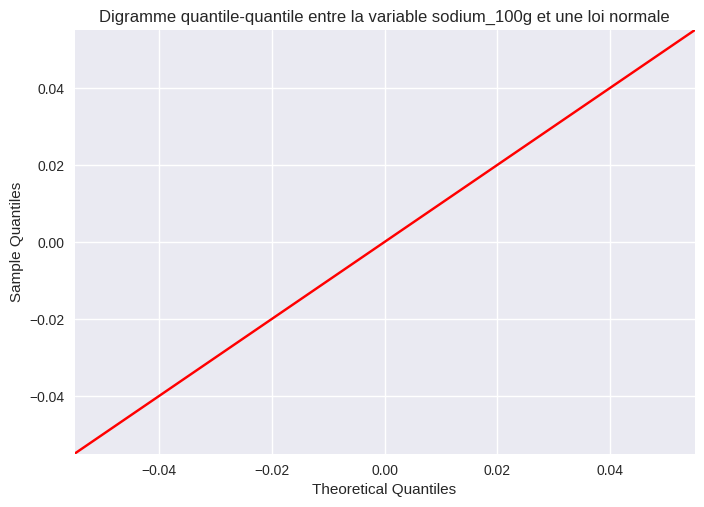

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=1.0, pvalue=1.0)

In [23]:
print(f"Mesure d'asymétrie empirique de la variable sodium_100g: {data['sodium_100g'].skew(axis=0)}")
print(f"Messure d'aplatissement empirique de la variable sodium_100g: {data['sodium_100g'].kurtosis(axis=0)}")
print("-"*50)
sm.qqplot(data["sodium_100g"].notna(), fit=True, line="45")
plt.title("Digramme quantile-quantile entre la variable sodium_100g et une loi normale")
plt.show()

shapiro(data["sodium_100g"].notna())

L'hypothèse H0 de normalité peut être rejetée avec un risque de 5%

Aucune de ces variables n'a une distribution suivant une loi normale. Il sera potentiellement nécessaire de leur appliquer une transformation pour les ramener à la normalité.**texte en gras**

# VARIABLE 'product_name':

In [24]:
print(f"Nombre de modalités: {data['product_name'].nunique()}")


Nombre de modalités: 29549


Au vu du grand nombre de modalités et du peu d'observations pour les modalités les plus représentées rendraient tout diagramme très peu lisible.

# VARIABLE 'brand':

In [25]:
print(f"Nombre de modalités: {data['brands'].nunique()}")


Nombre de modalités: 6515


Au vu du grand nombre de modalités et du peu d'observations pour les modalités les plus représentées rendraient tout diagramme très peu lisible.

# VARIABLE 'pnns_groups_1' :

Nombre de modalités: 9
Répartition des observations par modalité pnns_groups_1


,nombre_observations
pnns_groups_1,
sugary snacks,7272
milk and dairy products,4914
composite foods,4815
cereals and potatoes,4780
fish meat eggs,4265
beverages,3925
fruits and vegetables,2904
fat and sauces,1977
salty snacks,1661


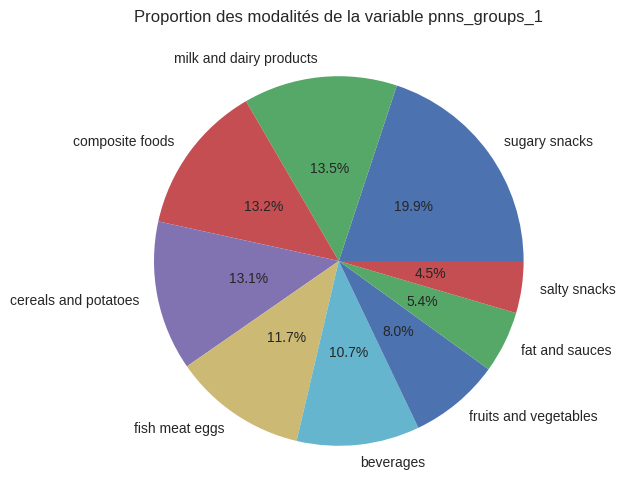

In [26]:
print(f"Nombre de modalités: {data['pnns_groups_1'].nunique()}")
pnns_g1_groupby = data.loc[:,["product_name","pnns_groups_1"]].groupby("pnns_groups_1").agg("count")
pnns_g1_groupby.rename(mapper={"product_name":"nombre_observations"}, axis=1, inplace=True)
pnns_g1_groupby.sort_values("nombre_observations", ascending= False, inplace = True)
print("Répartition des observations par modalité pnns_groups_1")
display(pnns_g1_groupby)

pie, ax = plt.subplots(figsize=(10,6))
labels = pnns_g1_groupby.index
plt.pie(x=pnns_g1_groupby["nombre_observations"], autopct="%.1f%%",  labels=labels, pctdistance=0.5)
plt.title("Proportion des modalités de la variable pnns_groups_1")
plt.show()

# VARIABLE 'pnns_groups_2' :

Nombre de modalités: 34
Répartition des observations par modalité pnns_groups_2


,nombre_observations,proportion
pnns_groups_2,,
one dish meals,3843,10.53
biscuits and cakes,3098,8.48
cereals,2381,6.52
sweets,2131,5.84
cheese,2126,5.82
processed meat,1964,5.38
dressings and sauces,1695,4.64
chocolate products,1677,4.59
milk and yogurt,1665,4.56


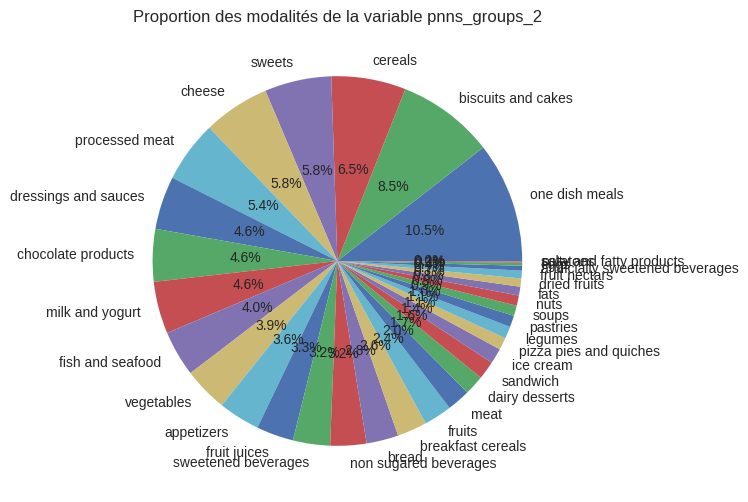

In [27]:
print(f"Nombre de modalités: {data['pnns_groups_2'].nunique()}")
pnns_g2_groupby = data.loc[:,["product_name","pnns_groups_2"]].groupby("pnns_groups_2").agg("count")
pnns_g2_groupby.rename(mapper={"product_name":"nombre_observations"}, axis=1, inplace=True)
pnns_g2_groupby.sort_values("nombre_observations", ascending= False, inplace = True)
pnns_g2_groupby["proportion"] = round(pnns_g2_groupby["nombre_observations"] / data.shape[0] * 100,2)

print("Répartition des observations par modalité pnns_groups_2")
display(pnns_g2_groupby)

pie, ax = plt.subplots(figsize=(10,6))
labels = pnns_g2_groupby.index
plt.pie(x=pnns_g2_groupby["nombre_observations"], autopct="%.1f%%",  labels=labels, pctdistance=0.5)
plt.title("Proportion des modalités de la variable pnns_groups_2")
plt.show()

# VARIABLE "nutrition_grade_fr" :

Nombre de modalités: 5
Répartition des observations par modalité pnns_groups_1


,nombre_observations
nutrition_grade_fr,
d,9959
c,7895
e,6856
a,6658
b,5145


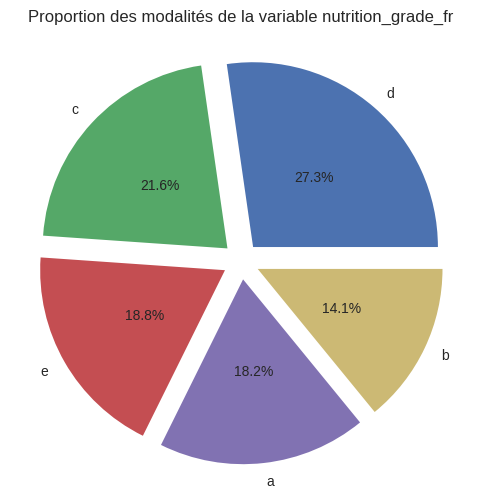

In [28]:
print(f"Nombre de modalités: {data['nutrition_grade_fr'].nunique()}")
nutriscore_grade_groupby = data.loc[:,["product_name","nutrition_grade_fr"]].groupby("nutrition_grade_fr").agg("count")
nutriscore_grade_groupby.rename(mapper={"product_name":"nombre_observations"}, axis=1, inplace=True)
nutriscore_grade_groupby.sort_values("nombre_observations", ascending= False, inplace = True)
print("Répartition des observations par modalité pnns_groups_1")
display(nutriscore_grade_groupby)

pie, ax = plt.subplots(figsize=(10,6))
labels = nutriscore_grade_groupby.index
plt.pie(x=nutriscore_grade_groupby["nombre_observations"], autopct="%.1f%%", explode=[0.1]*5, labels=labels, pctdistance=0.5)
plt.title("Proportion des modalités de la variable nutrition_grade_fr")
plt.show()

# 2. ANALYSE BIVARIEE

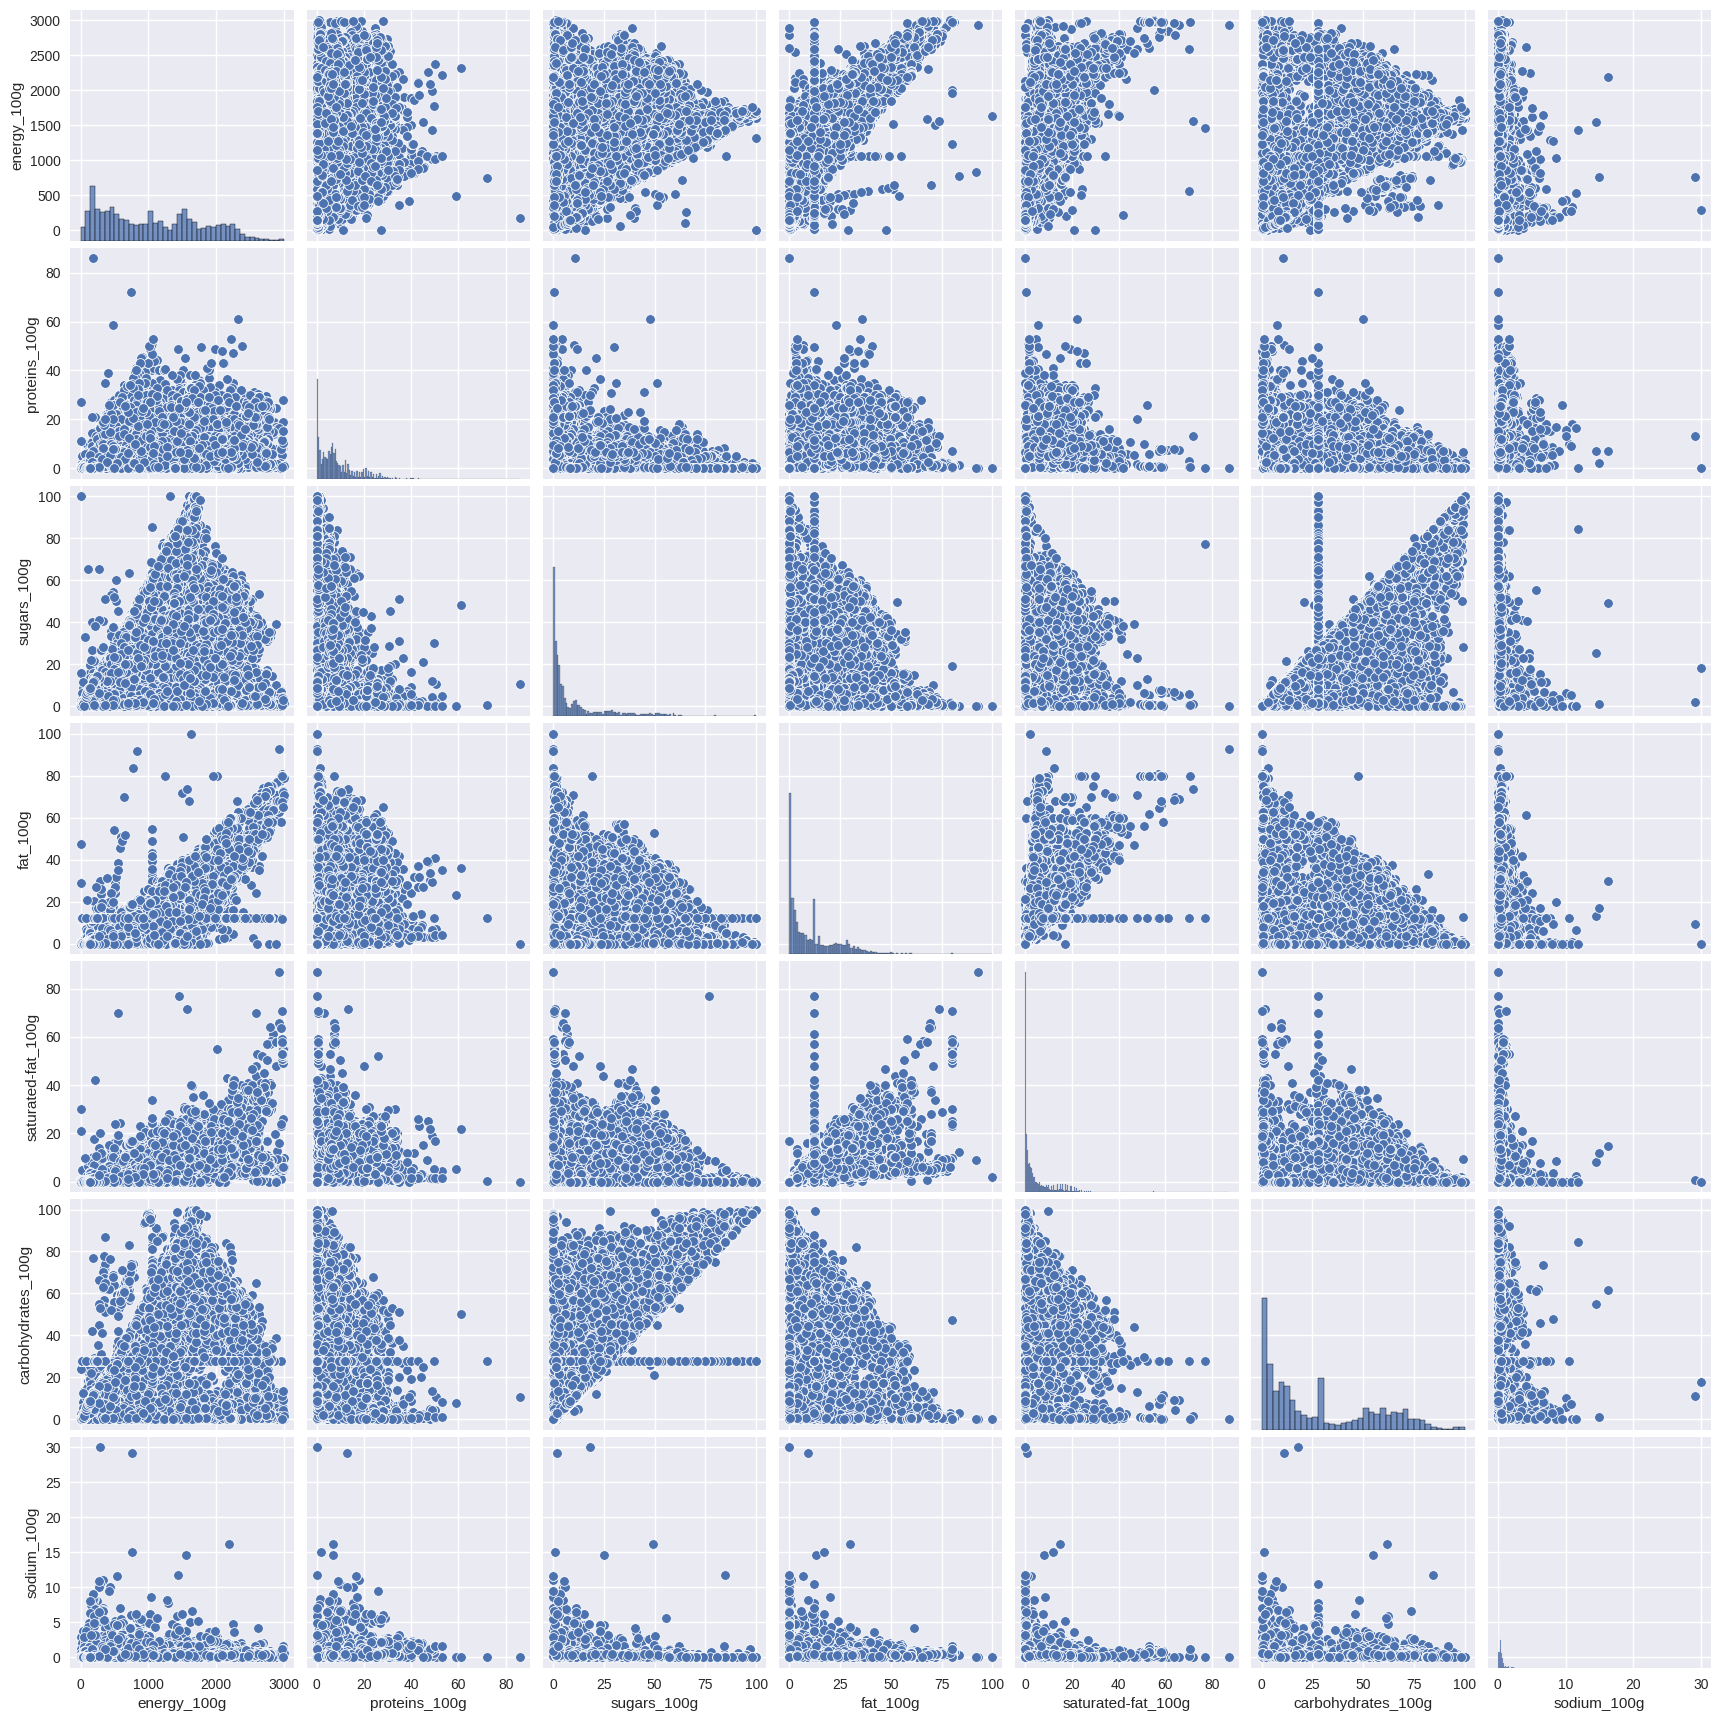

In [29]:
plot_cols =  [ "energy_100g", "proteins_100g", "sugars_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sodium_100g"]
quant_data = data.loc[:,plot_cols]
sns.pairplot(data=quant_data)
plt.show()

In [30]:
plot_cols =  ["energy_100g", "proteins_100g", "sugars_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sodium_100g", "nutrition_grade_fr"]
quant_data2 = data.loc[:,plot_cols]
sns.pairplot(data=quant_data2, hue="nutrition_grade_fr", palette="Set2")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [31]:
plot_cols =  ["energy_100g", "proteins_100g", "sugars_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sodium_100g", "pnns_groups_1"]
quant_data3 = data.loc[:,plot_cols]
sns.pairplot(data=quant_data3, hue="pnns_groups_1", palette="dark")
plt.show()


Output hidden; open in https://colab.research.google.com to view.

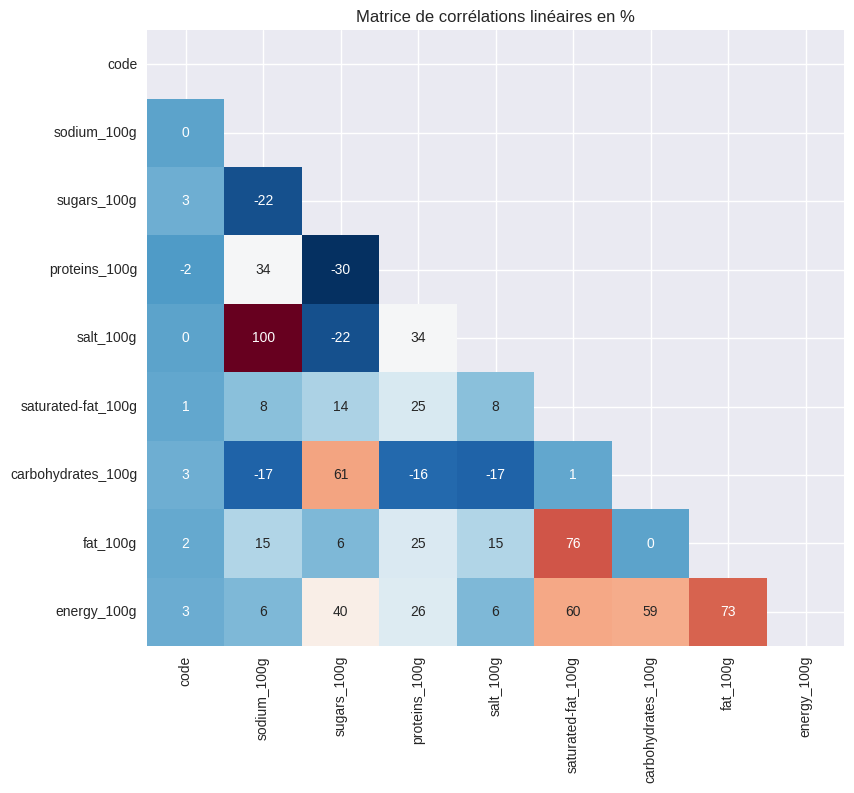

In [32]:
pearson_correlations = data.select_dtypes(include='float64').corr() * 100
cleanning_mask = np.zeros_like(pearson_correlations)
upper_triangle = np.triu_indices_from(pearson_correlations)
cleanning_mask[upper_triangle] = 1

plt.figure(figsize=(9,8))

sns.heatmap(pearson_correlations, cmap="RdBu_r", mask = cleanning_mask,
           annot = True, fmt=".0f", cbar=False)
plt.title("Matrice de corrélations linéaires en %")
plt.show()

# ANALYSE MULTIVARIEE

## ANNOVA

## analyse de variance

On effectue une analyse de variance pour mesurer l’indépendance entre une variable qualitative et une quantitative.

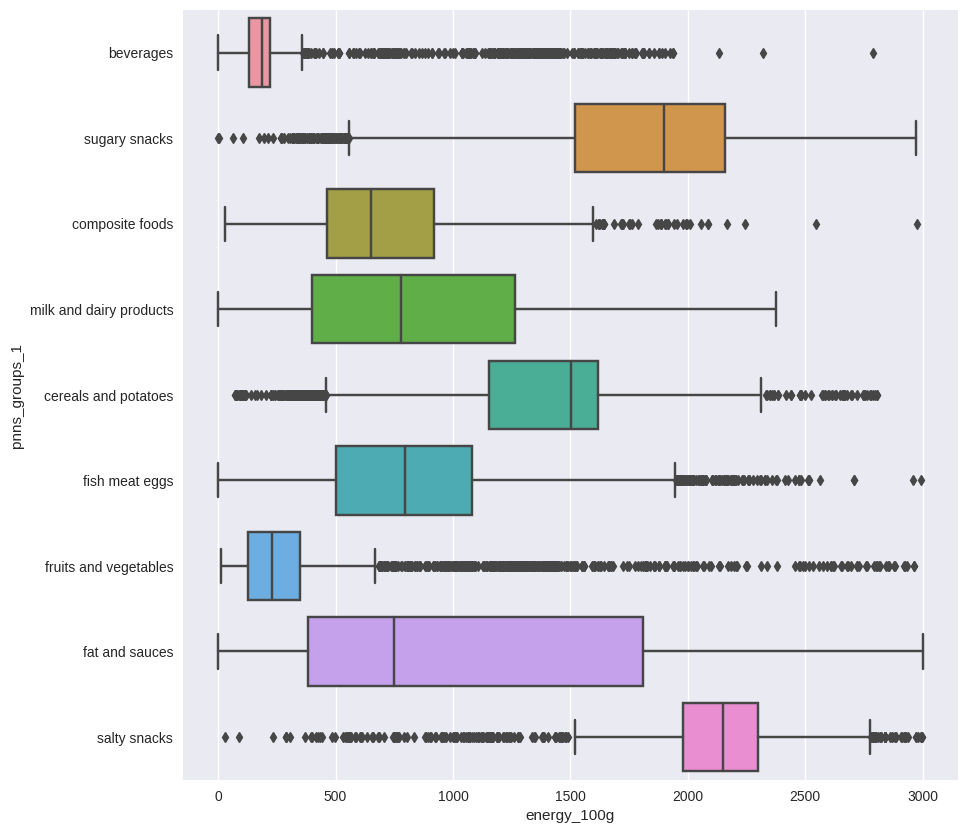

In [33]:
plt.subplots(figsize=(10,10))
ax = sns.boxplot(x="energy_100g", y="pnns_groups_1", data=data)


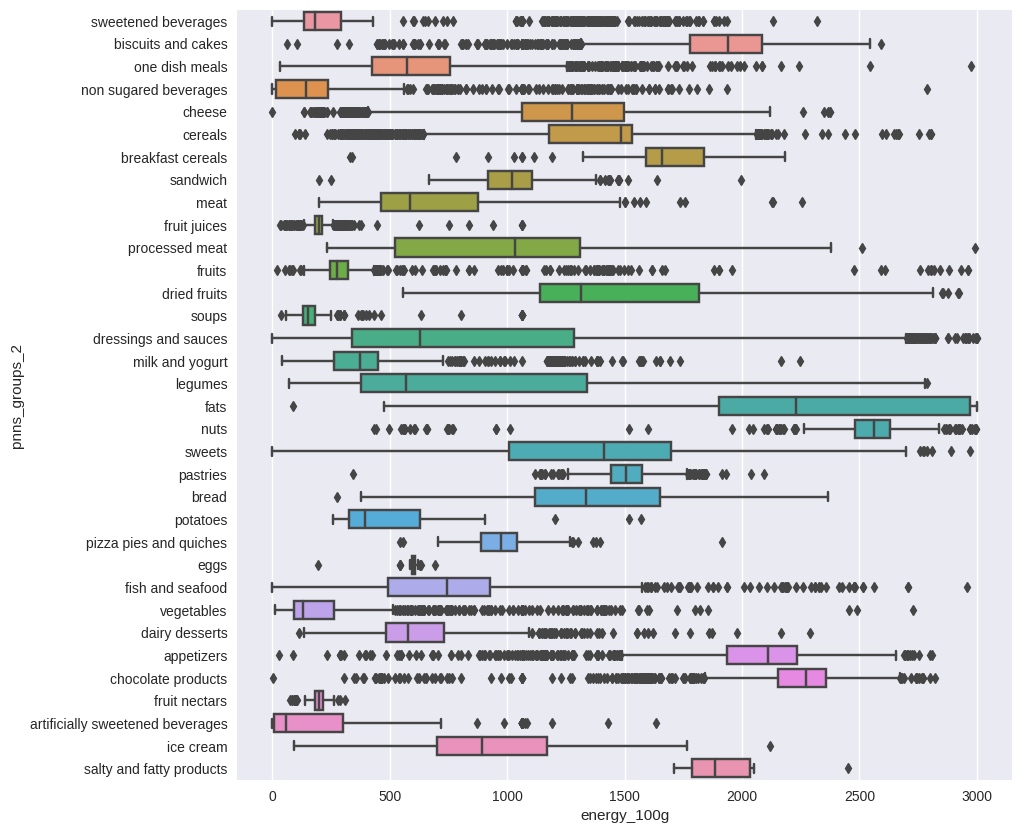

In [34]:
plt.subplots(figsize=(10,10))
ax = sns.boxplot(x="energy_100g", y="pnns_groups_2", data=data)

Dans une ANOVA, on cherche à déterminer si les moyennes des groupes sont significativement différentes. On pose donc :

H0 : Les moyennes de chaque groupe sont égales si p-value > 5%
H1 : Les moyennes de chaque groupe ne sont pas toutes égales si p-value < 5%

In [35]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('energy_100g ~ pnns_groups_2', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
pnns_groups_2,1.327677e+10,33.0,2526.922197,0.0
Residual,5.808038e+09,36479.0,NaN,NaN


H0 : Les moyennes de chaque groupe sont égales si p-value > 5%~
H1 : Les moyennes de chaque groupe ne sont pas toutes égales < 5%

L'indépendance
L’indépendance est une des 3 conditions de validité d’une ANOVA. Seul le contexte de l’étude permet de s’assurer de l’indépendance entre les échantillons de chaque groupe

L’égalité des variances
On parle aussi d’homoscédasticité. C’est une des 3 conditions de validité d’une ANOVA. On cherche à démontrer que les variances de chaque groupe sont égales. Dans un boxplot, l’amplitude des boîtes traduit graphiquement l’égalité des variances.

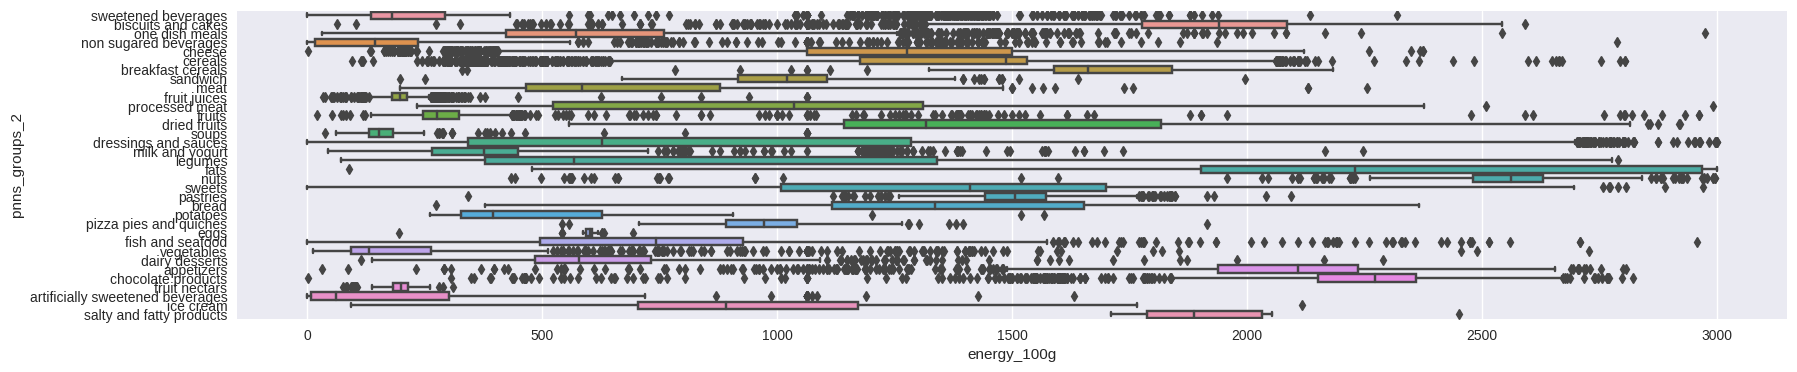

In [36]:
plt.subplots(figsize=(20,4))
ax = sns.boxplot(x="energy_100g", y="pnns_groups_2", data=data)

In [37]:
data.groupby("pnns_groups_1")["energy_100g"].agg('var')

pnns_groups_1
beverages                  141034.255913
cereals and potatoes       202365.497863
composite foods            101540.471872
fat and sauces             764570.705993
fish meat eggs             195252.795923
fruits and vegetables      251557.691625
milk and dairy products    239941.432027
salty snacks               197153.720680
sugary snacks              242746.466457
Name: energy_100g, dtype: float64

H0 : Les variances de chaque groupe sont égales si p-value > 5%
~H1 : Les variances de chaque groupe ne sont pas toutes égales < 5%~

## ACP

Nous réalisons l'analyse multivarié grâce à une ACP sur les variables quantitatives.

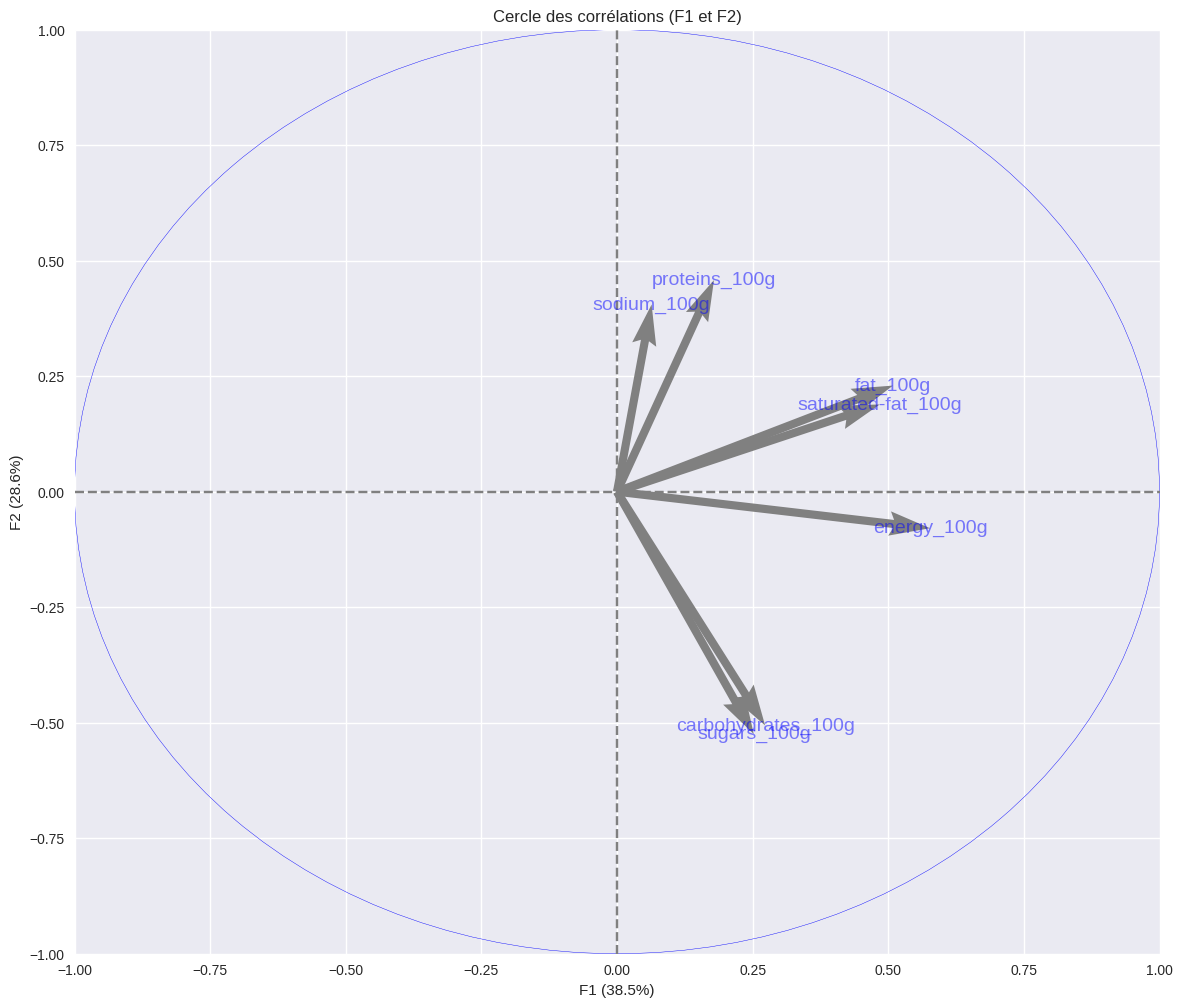

In [38]:
from sklearn import decomposition
from sklearn import preprocessing


def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(14,12))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:],
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))

            # affichage des noms des variables
            if labels is not None:
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(7,6))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)


filtered_cols = [ "energy_100g", "proteins_100g", "sugars_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "sodium_100g"]
X = data.loc[:, filtered_cols].values
features = data.loc[:, filtered_cols].columns
n_comp = 7

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)


pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

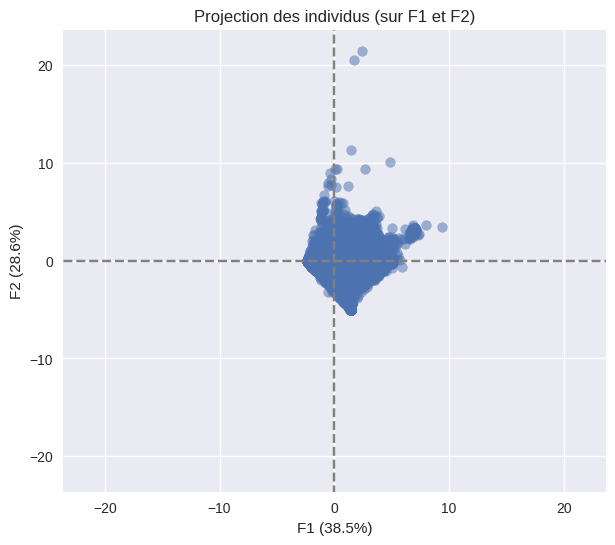

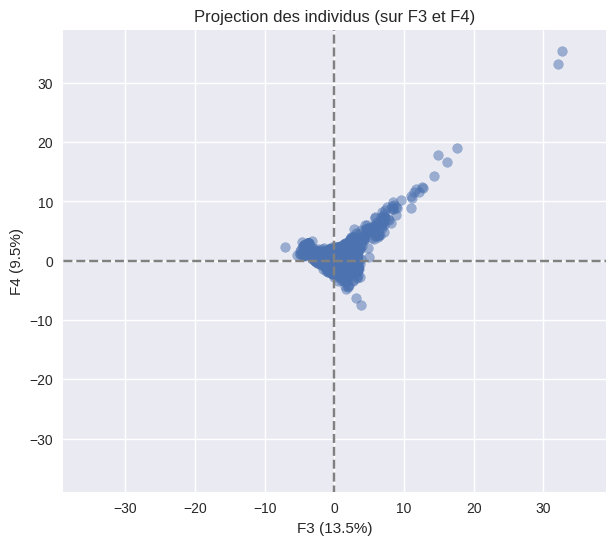

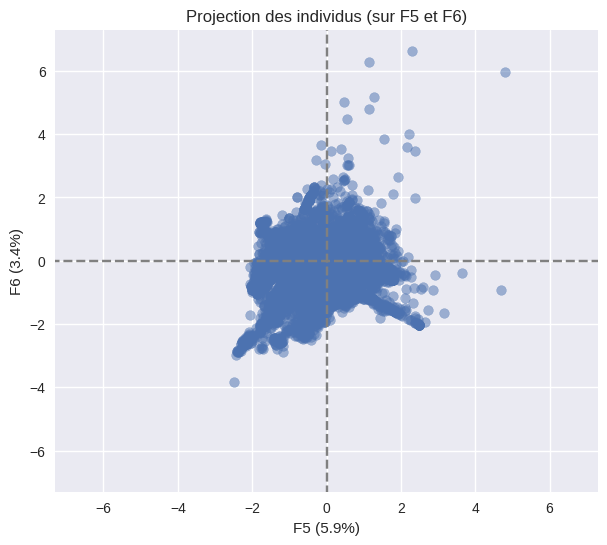

In [39]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], alpha = 0.5)

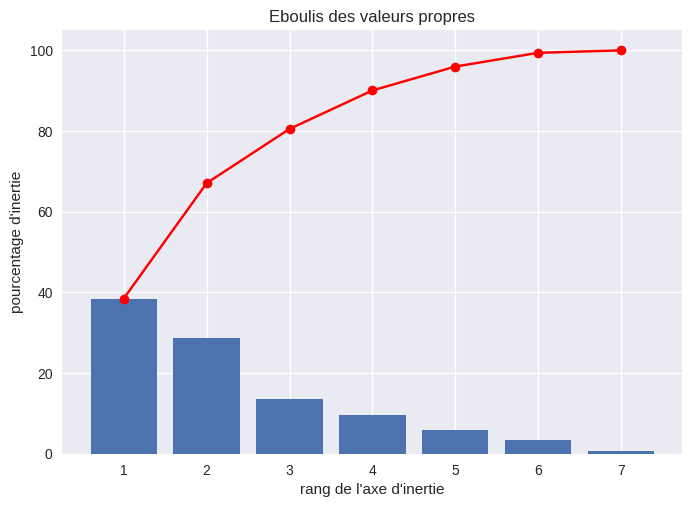

In [40]:
display_scree_plot(pca)

Il apparaît qu'il est nécessaire d'avoir recours à 3 composantes principales, pour 7 variables, afin de capter au moins 80% de l'inertie. Le phénomène explique d'une part des diagrammes difficilement exploitables voir pas interprétables et d'autre part un faible intérêt dans une recherche de réduction de dimensions.